In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


In [11]:
# Calculate the date 1 year ago from the last data point in the database
final_date=session.query(measurement.date).order_by(measurement.date.desc()).first().date 
final_date

'2017-08-23'

In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(measurement.date,measurement.prcp).\
                    filter(func.strftime("%Y-%m-%d", measurement.date) >= '2016-08-23').\
                    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns=['Date', 'Precipitation'])
precipitation_df.set_index('Date',inplace=True)
precipitation_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.00
2017-08-23,0.00


In [13]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date', ascending=True)
precipitation_df

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02
...,...
2017-08-22,0.50
2017-08-23,0.08
2017-08-23,0.00


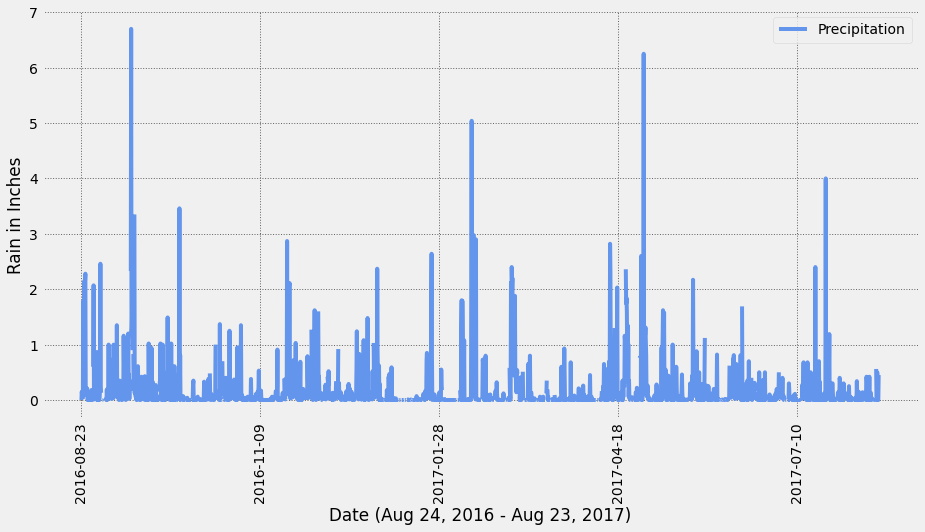

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
data_graph = precipitation_df.plot(color = "cornflowerblue",
                                   figsize =(14,7))

plt.ylabel('Rain in Inches')
plt.xlabel('Date (Aug 24, 2016 - Aug 23, 2017)')
plt.xticks(rotation ="90")
plt.grid(b=True, which='major', color='#666666', linestyle=':')

plt.savefig("output/precipitation.png",bbox_inches='tight');

plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe().round(3)

,Precipitation
count,2021.000
mean,0.177
std,0.461
min,0.000
25%,0.000
50%,0.020
75%,0.130
max,6.700


In [16]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(station.id).count()
station_count

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station))
as_sorted = active_stations.group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
as_sorted

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measurement.station,  
              func.min(measurement.tobs), 
              func.max(measurement.tobs), 
              func.avg(measurement.tobs),) .\
filter(measurement.station == "USC00519281").\
group_by(measurement.station).all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

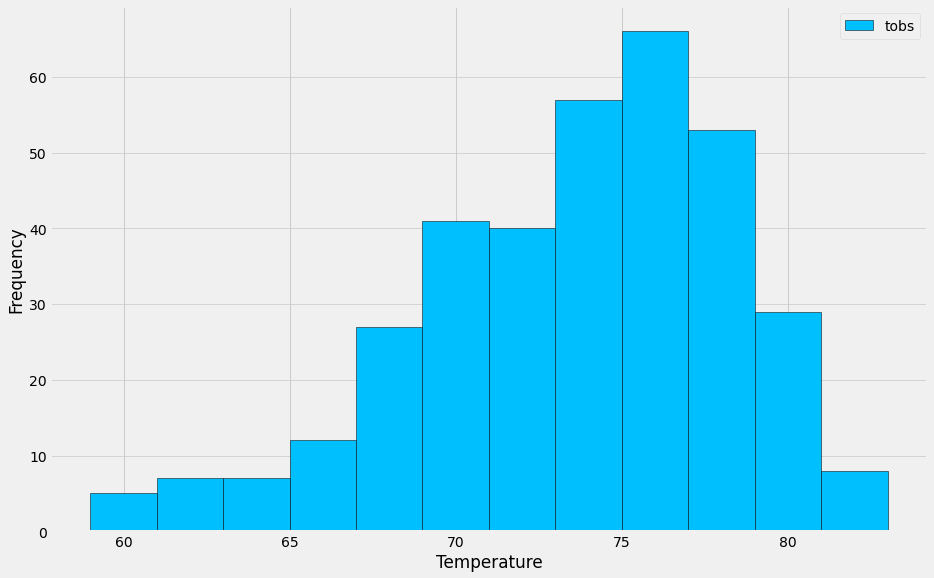

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
histogram = session.query(measurement.date,  measurement.tobs).\
                    filter(measurement.station == "USC00519281").\
                    filter(func.strftime("%Y-%m-%d", measurement.date) >= '2016-08-23').all()
histogram_df = pd.DataFrame(histogram, columns=['Date', 'Temperature'])
histogram_df = histogram_df.sort_values(by='Date', ascending=True)
histogram_df.set_index('Date', inplace=True)

plt.figure(figsize=[14,9]);

n, bins, patches = plt.hist(x=histogram_df["Temperature"], 
                            bins=12, 
                            color='deepskyblue',
                            edgecolor = "black",
                            label = "tobs")

plt.grid(axis='y', alpha=0.75);
plt.xlabel('Temperature');
plt.ylabel('Frequency');
plt.gca().legend(loc="best")
plt.title('')

plt.savefig("output/histogram.png",bbox_inches='tight');

plt.show()

## Bonus Challenge Assignment

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates


##### Note - I had to change the Measurement.tobs to measurement.tobs to match my data above for the example to work

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

print(calc_temps('2011-02-28', '2011-03-05'))

[(61.0, 69.75510204081633, 75.0)]


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
